# COMBLE-MIP Tutorial

* Please direct any questions to Tim Juliano (NSF NCAR, tjuliano@ucar.edu); updated 5/19/24

    * Credit to Florian Tornow (Columbia/NASA GISS) and Ann Fridlind (NASA GISS) for develping much of this code <br/><br/>

* The below notebook focuses on the DOE-funded Cold-Air Outbreaks in the Marine Boundary Layer Experiment (COMBLE) that took place from 2019-2020. More information about COMBLE can be found in Geerts et al. (2022). <br /><ins>Reference</ins><br />Geerts, B., et al., 2022: The COMBLE campaign: A study of marine boundary layer clouds in Arctic cold-air outbreaks, Bull. Amer. Meteor. Soc, 103, E1371–E1389. https://doi.org/10.1175/BAMS-D-21-0044.1

* To better understand the fundamental mixed-phase clouds that accompany cold-air outbreaks (CAOs), we initiated the COMBLE Model-Observation Intercomparison Project (MIP) for large-eddy simulation (LES) and single-column models (SCMs) in late 2021. The MIP examines a CAO event on 13 March 2020 that was observed during COMBLE. More details about COMBLE MIP may be found [here](https://arm-development.github.io/comble-mip/).

* The main goal of this notebook is to become more familiar with working with LES and SCM model outputs and comparing them to observations. Note that the figures below are generated from files that have been post-processed from raw LES outputs in order to be compliant with the COMBLE-MIP specifications. Please see the last section of this notebook for information about working with the raw LES outputs as well as post-processed outputs suitable for use with EMC^2.

* We will cover the following topics in this notebook:
    1. Reading MIP model outputs
    2. Plotting MIP model outputs
    3. Plotting ground-based ARM observations, satellite retrievals, and misc data sets

## Imports and path settings

Let’s get started with some data! But first, we need to import some libraries and define some functions. We'll do this through a Python script called 'functions_plotting_tutorial.py'

In [1]:
%run functions_plotting_tutorial.py

Point to the directory of the LES outputs

In [2]:
les_output_dir = '/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/'

## Read in observational data

Here, we consider DOE ARM data streams, several satellite data sources, as well two reanalyses products. Each of these data streams is read in using a unique function that is defined in 'functions_plotting_tutorial.py'. These data sets are important for us to evaluate our models.

**<ins>NOTE</ins>: We have already post-processed each of the below observational data sets. We expect that you will use the post-processed satellite and reanalyses data sets. However, since one of the foci of the Summer School is becoming more comfortable working with ARM data, you <ins>must</ins> work with the raw ARM data sets from the Data Discovery and post-process the data yourself!**

In [3]:
# Load DOE ARM data streams first
## radiosondes
rs_dat = load_rs(t_filter = 7.)
# KAZR
kazrkollias_dat = load_kazrkollias(t_filter = 6.,aux_dat=rs_dat) ## here using radiosonde profiles to estimate CTT
kazrclough_dat = load_kazrclough(t_filter = 6.)
# AERI
aeri_dat = load_aeri(t_filter = 0.5)
# radiative fluxes
radflux_dat = load_radflux(t_filter = 6.)
# surface fluxes
srfflux_dat = load_flux(t_filter = 6.)


## Load satellite data streams next
# multisensor advanced climatology of liquid water path (MAC-LWP)
# Elsaesser, G. S., O’Dell, C. W., Lebsock, M. D., Bennartz, R., Greenwald, T. J., & Wentz, F. J. (2017).
# The multisensor advanced climatology of liquid water path (MAC-LWP). Journal of Climate, 30(24), 10193-10210.
maclwp_dat = load_maclwp(t_filter = 0.)
# MODIS
modis_dat = load_modis(t_filter = 0.,sza_filter = 65.)
# VIIRS
viirs_dat = load_viirs(t_filter = 0.,sza_filter = 65.)
# Sentinel
sentinel_dat = load_sentinel(t_filter = 0.,sza_filter = 65.)
# CALIPSO (note the increased time window)
calipso_dat = load_calipso(t_filter = 3.)


## Load reanlyses data streams last
# ERA5
era5_1d, era5_2d = load_era5()
# CARRA
carra_dat = load_carraflux()

/data/project/ARM_Summer_School_2024_Data/comble-mip/data_files/anxsondewnpnM1.b1.20200313.112600.cdf
/data/project/ARM_Summer_School_2024_Data/comble-mip/data_files/anxsondewnpnM1.b1.20200313.052700.cdf
/data/project/ARM_Summer_School_2024_Data/comble-mip/data_files/anxsondewnpnM1.b1.20200313.232200.cdf
/data/project/ARM_Summer_School_2024_Data/comble-mip/data_files/anxsondewnpnM1.b1.20200313.172600.cdf
KAZR (Kollias): here using auxiliary field to estimate cloud-top temperature
/data/project/ARM_Summer_School_2024_Data/comble-mip/data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc


/data/home/tjuliano/arm-summer-school-2024/tutorials/comble/functions_plotting_tutorial.py:242: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux_dat['zdiff'] = np.abs(aux_dat['zf'] - float(p_df['zi']))
/data/home/tjuliano/arm-summer-school-2024/tutorials/comble/functions_plotting_tutorial.py:243: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux_dat['zdiff.25'] = np.abs(aux_dat['zf'] - float(p_df['zi.25']))
/data/home/tjuliano/arm-summer-school-2024/tutorials/comble/functions_plotting_tutorial.py:244: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux_dat['zdiff.75'] = np.abs(aux_dat['zf'] - float(p_df['zi.75']))


## Read in MIP model outputs

Let's compare two participating LES models: the Weather Research and Forecasting (WRF) model and the Distributed Hydrodynamic-Aerosol-Radiation-Microphysics Application (DHARMA).

In [4]:
# we will use the 'FixN' model configuration (this is the baseline setup for the MIP)
# two other configurations can be examined: 'FixN_noice' and 'FixN_def_z0'
# more details about the MIP model configuration: https://arm-development.github.io/comble-mip/main_configuration.html
sim_keyword_wrf = 'wrf/WRF_Lx25_dx100_FixN.'
sim_keyword_dharma = 'dharma/DHARMA_Lx25_dx200_FixN.'

First, we will load in specified 1D variables (time dimension only) from the simulation outputs of these two models to compare with some of the observational products. It is important to understand how close our simulations are to the reanalyses and observations with respect to surface-related variables because CAOs are very strongly surface forced. Turbulent exchanges between the ocean and atmosphere largely dictate how the cloud system evolves.

In [5]:
# define variables
var_vec_1d = ['hfss','hfls','ts'] # surface sensible and latent heat flux, as well as skin temperature
var_vec_2d = []
# wrf
df_col_wrf_1d,df_col_wrf_2d = load_sims(les_output_dir,var_vec_1d,var_vec_2d,t_shift=-2,
                                        keyword=sim_keyword_wrf)
# dharma
df_col_dharma_1d,df_col_dharma_2d = load_sims(les_output_dir,var_vec_1d,var_vec_2d,t_shift=-2,
                                              keyword=sim_keyword_dharma)

Loading variables: f(time)
/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN.nc
Loading variables: f(time,height)
/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN.nc
Loading variables: f(time)
/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/dharma/DHARMA_Lx25_dx200_FixN.nc
Loading variables: f(time,height)
/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/dharma/DHARMA_Lx25_dx200_FixN.nc


## Plotting observations and MIP outputs

#### Let's now read in and plot some surface variables
hfss --> surface sensible heat flux (W/m2)\
hfls --> surface latent heat flux (W/m2)\
ts --> skin temperature (K)\
Note that t=0h corresponds to the ice edge

/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


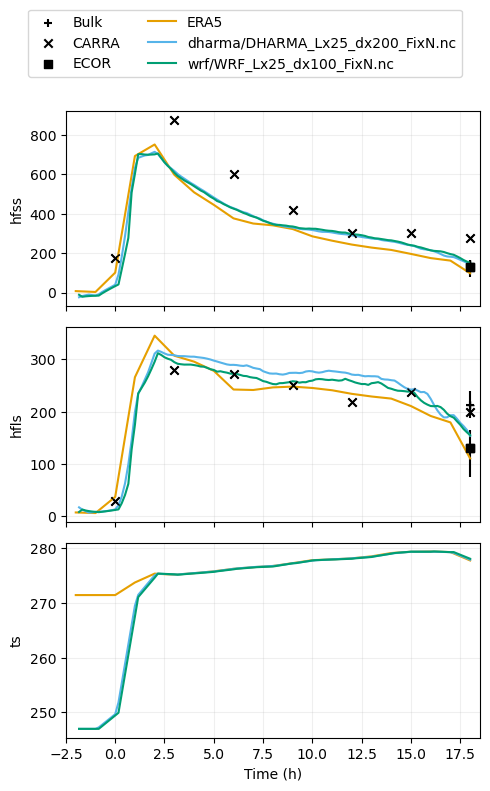

In [6]:
## plot variables that have only time dependence
plot_1d(pd.concat([df_col_wrf_1d,df_col_dharma_1d,era5_1d,carra_dat,srfflux_dat]),var_vec_1d)

#### Let's now read in and plot some cloud-centric variables
cth --> cloud top height (m)\
od --> optical depth (-)\
lwp --> liquid water path (g/m2)\
iwp --> ice water path (g/m2)\
ctt --> cloud top temperature (K)

In [7]:
# define variables
var_vec_1d = ['lwpr','lwpc','iwp','od'] # variables without ERA5 (shorter time axis)
var_vec_2d = ['theta','qv','qlc','qlr','qic','qis','qig','ua','va','ta']
# wrf
df_col_wrf_1d,df_col_wrf_2d = load_sims(les_output_dir,var_vec_1d,var_vec_2d,t_shift=-2,
                                        keyword=sim_keyword_wrf,diag_zi_ctt=True)
# dharma
df_col_dharma_1d,df_col_dharma_2d = load_sims(les_output_dir,var_vec_1d,var_vec_2d,t_shift=-2,
                                              keyword=sim_keyword_dharma,diag_zi_ctt=True)

Loading variables: f(time)
/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN.nc
Loading variables: f(time,height)
/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN.nc
computing inversion height, cloud-top height, and cloud-top temperature
using liquid(-ice) potential temperature
Loading variables: f(time)
/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/dharma/DHARMA_Lx25_dx200_FixN.nc
Loading variables: f(time,height)
/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/dharma/DHARMA_Lx25_dx200_FixN.nc
computing inversion height, cloud-top height, and cloud-top temperature
using liquid(-ice) potential temperature


/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


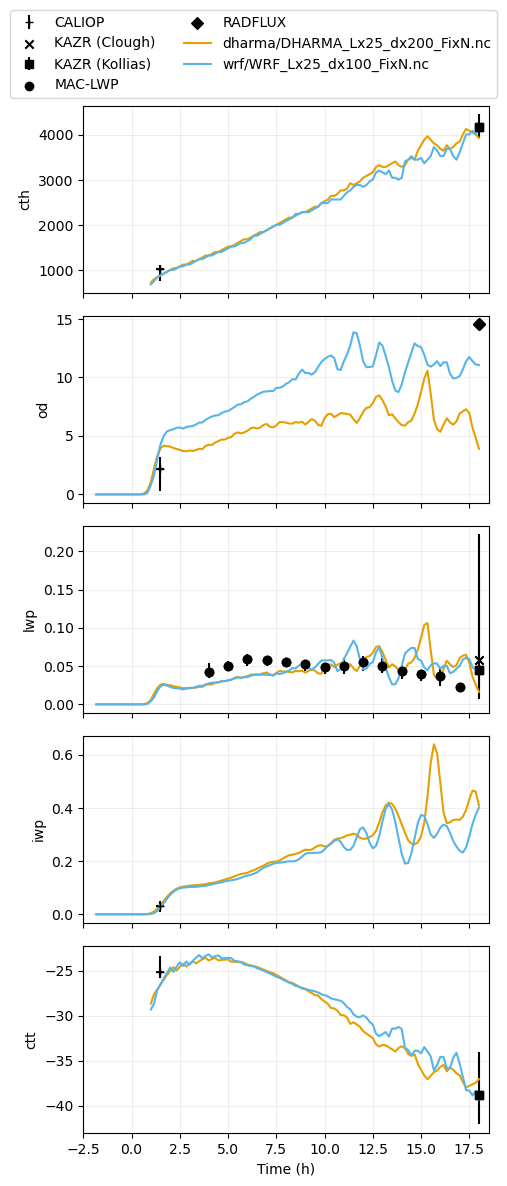

In [8]:
plot_1d(pd.concat([df_col_wrf_1d,df_col_dharma_1d,maclwp_dat,kazrkollias_dat,kazrclough_dat,calipso_dat,radflux_dat]),['cth','od','lwp','iwp','ctt'])

#### And lastly, some vertical profiles
* Note that we have ERA5 during the entire particle trajectory and COMBLE measurements only at the last time (t=18h)

ta --> air temperature (K)\
theta --> air potential temperature (K)\
qv --> water vapor mixing ratio (kg/kg)\
ws --> wind speed (m/s)\
wd --> wind direction (deg)

Computing wind speed
Computing wind direction


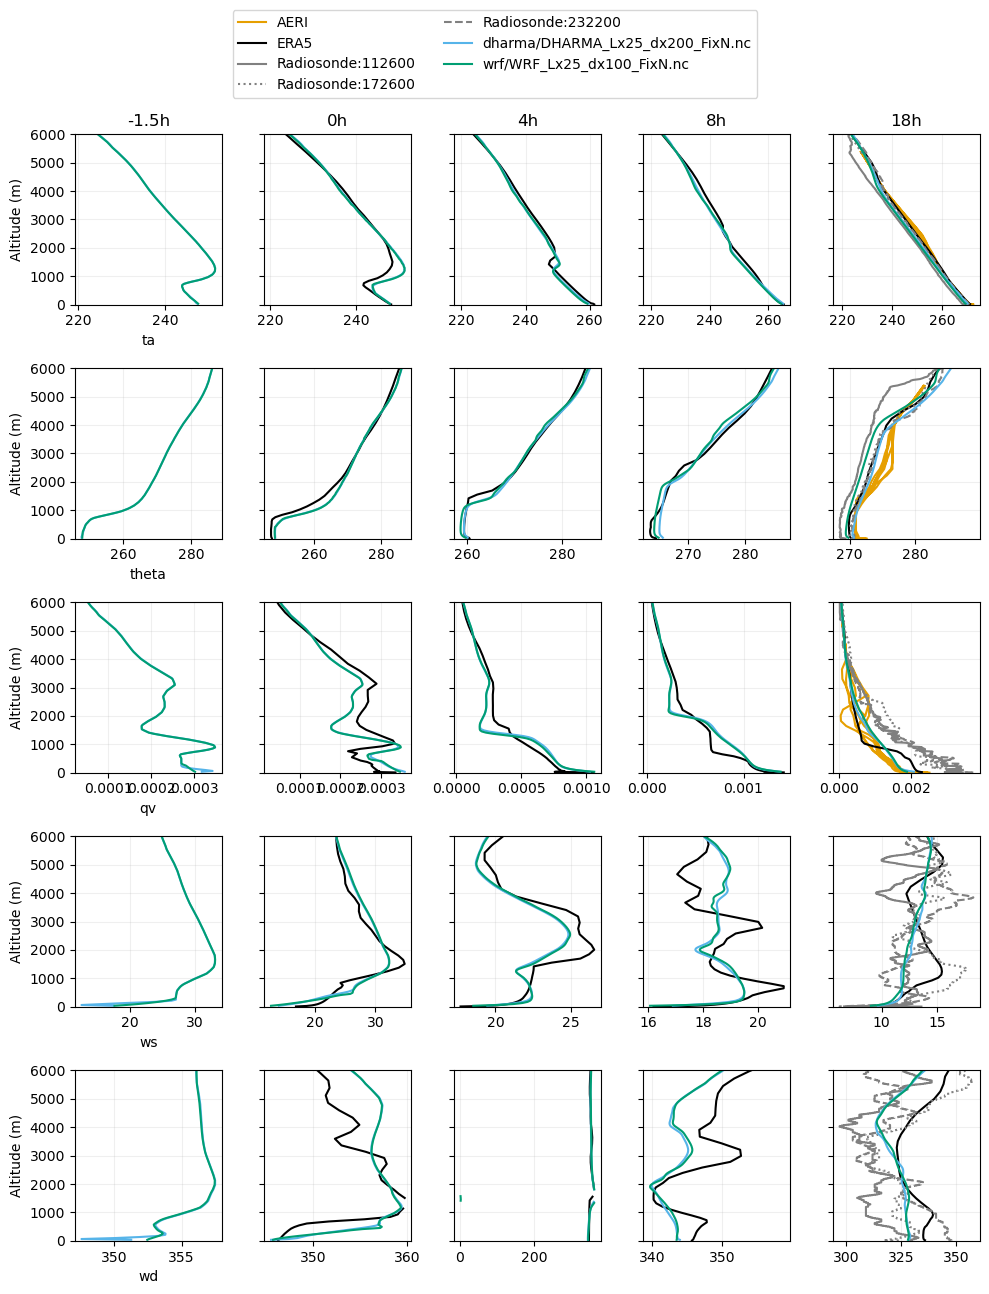

<Figure size 1000x600 with 0 Axes>

In [9]:
plot_2d(pd.concat([df_col_wrf_2d,df_col_dharma_2d,era5_2d,rs_dat,aeri_dat]),var_vec = ['ta','theta','qv','ws','wd'],times=[-1.5,0,4,8,18],z_max=6000)

## Information about additional model outputs
* This tutorial has covered working with LES outputs compliant with the COMBLE-MIP specifications. While these files allow us to convieniently compare the WRF and DHARMA results, it may be useful to dig into the raw model output files, which include more detailed information.

#### Raw WRF-LES outputs

The raw WRF output files for the 'FixN' simulation may be found here:

In [10]:
raw_wrf_output_dir = '/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_raw/'

Let's gather all of the 'wrfstat' files, which contain time-averaged (over 10-min intervals, time stamped at the end of the period) 1D, 2D, and 3D variables:

In [11]:
raw_wrfstat_files = sorted(glob.glob(raw_wrf_output_dir+'wrfstat*'))

It's important to note that the WRF configuration used for this simulation follows the LASSO codebase. More details about LASSO may be found [here](https://www.arm.gov/capabilities/modeling/lasso/). Thus, the 'wrfstat' files contain a very similar set of variables as described in the [Overview of LASSO-ShCu Data for Southern Great Plains](https://arm-development.github.io/arm-summer-school-2024/tutorials/lasso/lasso-shcu.html) and the [Part 2 of LASSO-ShCu Tutorial: Quick-look 3-D Isosurface Plotting](https://arm-development.github.io/arm-summer-school-2024/tutorials/lasso/lasso-shcu_part2.html) Notebooks developed by William Gustafson as part of this year's DOE ARM Summer School. **If you would like to work with the 'wrfstat' files, then please review these two Notebooks to better understand how to work with the data.**

We can also gather all of 'wrfout' files, which contain instantaneous fields at each hour:

In [12]:
raw_wrfout_files = sorted(glob.glob(raw_wrf_output_dir+'wrfout*'))

We can use ```xarray``` and ```xwrf``` to read and inspect one of the 'wrfout' files at 16 UTC on 03-13
* See the following links for an [xarray tutorial ](https://arm-development.github.io/arm-summer-school-2024/tutorials/xarray/xarray-intro.html) and an [xwrf tutorial](https://arm-development.github.io/arm-summer-school-2024/tutorials/xarray/xwrf-xarray-intro.html)

In [13]:
filename = raw_wrfout_files[18]
ds = xr.open_dataset(filename).xwrf.postprocess()
ds

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


<xarray.Dataset> Size: 5GB
Dimensions:                    (Time: 1, y: 256, x: 256, soil_layers_stag: 5,
                                z: 159, x_stag: 257, y_stag: 257, z_stag: 160,
                                seed_dim_stag: 2, force_layers: 136)
Coordinates: (12/15)
    XLAT                       (y, x) float32 262kB 74.0 74.0 74.0 ... 74.0 74.0
    XLONG                      (y, x) float32 262kB 10.0 10.0 10.0 ... 10.0 10.0
    XTIME                      (Time) datetime64[ns] 8B ...
    XLAT_U                     (y, x_stag) float32 263kB 0.0 0.0 0.0 ... 0.0 0.0
    XLONG_U                    (y, x_stag) float32 263kB 0.0 0.0 0.0 ... 0.0 0.0
    XLAT_V                     (y_stag, x) float32 263kB 0.0 0.0 0.0 ... 0.0 0.0
    ...                         ...
  * z_stag                     (z_stag) float32 640B 1.0 0.9957 ... 0.002635 0.0
  * Time                       (Time) datetime64[ns] 8B 2020-03-13T16:00:00
  * x                          (x) float64 2kB -1.275e+04 ... 1.275e+04
  * y                          (y) float64 2kB -1.275e+04 ... 1.275e+04
  * x_stag                     (x_stag) float64 2kB -1.28e+04 ... 1.28e+04
  * y_stag                     (y_stag) float64 2kB -1.28e+04 ... 1.28e+04
Dimensions without coordinates: soil_layers_stag, seed_dim_stag, force_layers
Data variables: (12/320)
    Times                      (Time) |S19 19B b'2020-03-13_16:00:00'
    LU_INDEX                   (Time, y, x) float32 262kB ...
    ZS                         (Time, soil_layers_stag) float32 20B ...
    DZS                        (Time, soil_layers_stag) float32 20B ...
    VAR_SSO                    (Time, y, x) float32 262kB ...
    U                          (Time, z, y, x_stag) float32 42MB ...
    ...                         ...
    geopotential               (Time, z_stag, y, x) float32 42MB 0.0 ... 6.93...
    geopotential_height        (Time, z_stag, y, x) float32 42MB 0.0 ... 7.07...
    wind_east                  (Time, z, y, x) float32 42MB -0.6366 ... 2.329
    wind_north                 (Time, z, y, x) float32 42MB -12.42 ... -10.5
    wind_east_10               (Time, y, x) float32 262kB -0.569 ... 0.3957
    wind_north_10              (Time, y, x) float32 262kB -12.34 ... -12.67
Attributes: (12/132)
    TITLE:                            OUTPUT FROM WRF V4.2.2 MODEL
    START_DATE:                      2020-03-12_22:00:00
    SIMULATION_START_DATE:           2020-03-12_22:00:00
    WEST-EAST_GRID_DIMENSION:        257
    SOUTH-NORTH_GRID_DIMENSION:      257
    BOTTOM-TOP_GRID_DIMENSION:       160
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

Let's plot up the 2m temperature field (variable name 'T2'). This field lets us visualize cold pools associated with precipitating convective cells.

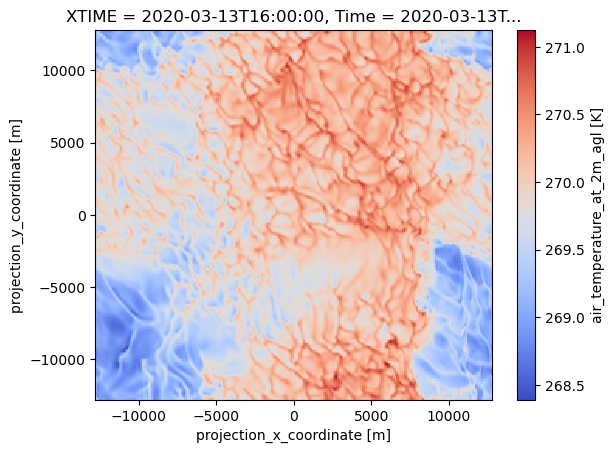

In [14]:
ds.T2.plot(x='x',
            y='y',
            cmap='coolwarm')

#### Processed EMC^2 files

In addition to the raw model outputs, we have post-processed the WRF and DHARMA outputs for use with EMC^2. Those files may be found at the following paths:
* WRF: ```/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_raw/emc2_prep*```
* DHARMA: ```/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/dharma/emc2/emc2_prep*```

EMC^2-ready files from WRF are available hourly while the three DHARMA files *11521.tgz, *20296.tgz, and *29549.tgz are from 06, 12, and 18 UTC, respectively.

While we won't cover how to run EMC^2 with the LES files in this tutorial, Robert Jackson has [developed a tutorial covering this topic](https://arm-development.github.io/arm-summer-school-2024/tutorials/emc2/InstrumentSimulatorsForModelEvaluation.html). **Please go through that tutorial if you are interested in working with EMC^2 for COMBLE-MIP.**